# Data Consistency

This notebook investigates potential data inconsistencies in the log database (ie. connectivity_events).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import aux_balena as aux
import importlib
from datetime import datetime, timedelta
%matplotlib inline

## Connectivity events

In [2]:
dflog = aux.read_base_log()

Mem. usage decreased to 142.03 Mb (51.5% reduction)
Log read in 10.3 s
Converting to timestamp field:  timestamp
Done!


In [3]:
dflog.head()

timestamp  device_id  user_id  server_id  connected
0 2015-05-31 14:30:00        100        4          2       True
1 2015-05-31 14:30:00        101        1          2       True
2 2015-05-31 14:30:00        102        1          2       True
3 2015-05-31 14:30:00        103       26          2       True
4 2015-05-31 14:30:00        104        1          2       True

#### Timestamp analysis

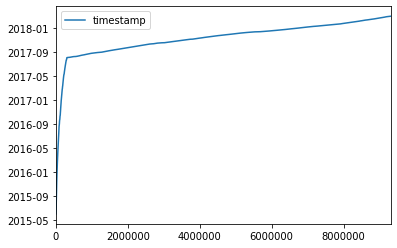

In [4]:
dflog.plot.line(y='timestamp');

In [5]:
sum(dflog.timestamp.diff()<timedelta(milliseconds=0))

16114

Although timestamps seem to be in progressive order in the log database, there is actually a small number of points where this is not the case.

It will be necessary to reorder the database before modifying it.

The dataset will be sorted by device_id first and then by timestamp.

In [63]:
dsort = dflog.sort_values(by=['device_id','timestamp'])
dsort = dsort.reset_index()
dsort.head()

index           timestamp  device_id  user_id  server_id  connected
0     14 2015-05-31 14:30:00          1        1          2       True
1    857 2015-06-02 10:30:00          1        1          2      False
2    137 2015-05-31 14:30:00          2        2          2       True
3   2098 2015-06-05 20:30:00          2        2          2      False
4    173 2015-05-31 14:30:00          3        1          2       True

Now that the dataset is sorted, check if there are duplicate timestamps

In [64]:
duplicate_timestamps_count = \
    dsort.groupby('device_id')['timestamp'].apply(
    lambda x: sum((x.diff()/timedelta(microseconds=1))==0) )
duplicate_timestamps_count.sort_values(ascending=False,inplace=True)

In [65]:
duplicate_timestamps_count.head()

device_id
9529     20
20872     4
20384     2
40383     2
43930     1
Name: timestamp, dtype: int64

In [10]:
sum(duplicate_timestamps_count>0)

18

In [30]:
sum(duplicate_timestamps_count)

42

It results that 18 devices have at least one duplicate timestamp in their time series. There are 42 duplicates overall.

The device with most duplicate timestamps is 9529, which is also the one with most datapoints (see [01_EDA](01_EDA.ipynb) notebook)



Let us investigate the sections with duplicates

In [66]:
dupl = dsort.copy()
# timedelta between successive timestamps expressed in microseconds
dupl['timedelta'] = dupl.timestamp.diff()/timedelta(microseconds=1)
# difference between successive device_id in the frame [used to separate different device_id's]
dupl['dev_diff'] = dupl.device_id.diff()

In [67]:
# frame with duplicate datapoints
dupl=dupl[(dupl.timedelta==0) & (dupl.dev_diff==0)]

In [68]:
dupl.head()

index               timestamp  device_id  user_id  server_id  \
436333   3011361 2017-10-17 05:04:11.604       7986     1275         16   
1291695  2041457 2017-09-23 06:26:10.484       9529      168         12   
1625394  3006648 2017-10-17 01:37:01.776       9529      168         16   
1810510  3524691 2017-10-30 03:56:21.697       9529      168         16   
1878320  3783295 2017-11-04 00:57:51.039       9529      168         18   

         connected  timedelta  dev_diff  
436333        True        0.0       0.0  
1291695       True        0.0       0.0  
1625394       True        0.0       0.0  
1810510       True        0.0       0.0  
1878320       True        0.0       0.0

To investigate duplicates, it is necessary to extract the datapoints immediately preceding those found in the 'dupl' dataframe

In [69]:
ix_dupl = dupl.index.values
#
ix_prec = ix_dupl-1

In [70]:
ix_interest = np.unique(np.concatenate((ix_dupl, ix_prec)))

In [71]:
# subframe with points of interest
dsub = dsort.loc[ix_interest]
dsub.head()

index               timestamp  device_id  user_id  server_id  \
436332   3011360 2017-10-17 05:04:11.604       7986     1275         16   
436333   3011361 2017-10-17 05:04:11.604       7986     1275         16   
1291694  2041456 2017-09-23 06:26:10.484       9529      168         12   
1291695  2041457 2017-09-23 06:26:10.484       9529      168         12   
1625393  3006647 2017-10-17 01:37:01.776       9529      168         16   

         connected  
436332       False  
436333        True  
1291694      False  
1291695       True  
1625393      False

Count how many duplicates there are for each case

In [54]:
dsub.groupby(['device_id','timestamp'])['connected'].count().to_frame()

connected
device_id timestamp                         
7986      2017-10-17 05:04:11.604          2
9529      2017-09-23 06:26:10.484          2
          2017-10-17 01:37:01.776          2
          2017-10-30 03:56:21.697          2
          2017-11-04 00:57:51.039          2
          2017-11-22 00:15:50.191          2
          2017-11-22 00:30:44.750          2
          2017-11-22 05:07:16.688          2
          2017-11-22 06:31:17.988          2
          2017-11-22 06:33:32.768          2
          2017-11-24 21:08:00.306          2
          2017-11-24 22:57:25.152          2
          2017-11-28 06:30:21.175          2
          2017-12-05 22:30:41.003          2
          2017-12-05 22:59:31.235          2
          2017-12-06 02:04:49.761          2
          2017-12-12 01:12:38.314          2
          2017-12-14 22:08:06.845          2
          2018-01-03 06:08:33.886          2
          2018-01-16 19:37:28.539          2
          2018-01-16 20:40:18.460          2
15433     2017-10-17 05:00:32.686          2
18393     2017-11-04 00:33:32.079          2
19326     2018-02-17 02:58:58.809          2
20042     2017-11-23 01:35:44.290          2
20044     2017-11-23 01:22:34.387          2
20049     2017-11-23 02:06:50.496          2
20384     2017-11-04 01:46:24.289          2
          2017-11-20 19:01:08.795          2
20872     2017-10-17 04:28:30.675          2
          2017-11-23 01:59:03.947          2
          2017-11-24 15:59:23.683          2
          2018-01-08 20:08:13.843          2
31370     2017-10-03 15:08:47.642          2
38315     2018-02-12 21:00:57.173          2
40383     2017-11-23 02:44:23.796          2
          2017-11-24 23:11:43.546          2
41846     2018-02-12 07:51:54.130          2
43445     2017-12-11 23:42:13.367          2
43930     2018-02-23 19:55:27.692          2
50167     2018-01-27 00:45:07.643          2
52805     2018-02-22 23:57:28.162          2

Each duplication occurs with exactly 2 datapoints.

Now count how many different values there are in 'connected' at each duplicate, to understand if it's just a repetition or not

In [55]:
dsub.groupby(['device_id','timestamp'])['connected'].apply(aux.nunique).to_frame()

connected
device_id timestamp                         
7986      2017-10-17 05:04:11.604          2
9529      2017-09-23 06:26:10.484          2
          2017-10-17 01:37:01.776          2
          2017-10-30 03:56:21.697          2
          2017-11-04 00:57:51.039          2
          2017-11-22 00:15:50.191          2
          2017-11-22 00:30:44.750          2
          2017-11-22 05:07:16.688          2
          2017-11-22 06:31:17.988          2
          2017-11-22 06:33:32.768          2
          2017-11-24 21:08:00.306          2
          2017-11-24 22:57:25.152          2
          2017-11-28 06:30:21.175          2
          2017-12-05 22:30:41.003          2
          2017-12-05 22:59:31.235          2
          2017-12-06 02:04:49.761          2
          2017-12-12 01:12:38.314          2
          2017-12-14 22:08:06.845          2
          2018-01-03 06:08:33.886          2
          2018-01-16 19:37:28.539          2
          2018-01-16 20:40:18.460          2
15433     2017-10-17 05:00:32.686          2
18393     2017-11-04 00:33:32.079          2
19326     2018-02-17 02:58:58.809          2
20042     2017-11-23 01:35:44.290          2
20044     2017-11-23 01:22:34.387          2
20049     2017-11-23 02:06:50.496          2
20384     2017-11-04 01:46:24.289          2
          2017-11-20 19:01:08.795          2
20872     2017-10-17 04:28:30.675          2
          2017-11-23 01:59:03.947          2
          2017-11-24 15:59:23.683          2
          2018-01-08 20:08:13.843          2
31370     2017-10-03 15:08:47.642          2
38315     2018-02-12 21:00:57.173          2
40383     2017-11-23 02:44:23.796          2
          2017-11-24 23:11:43.546          2
41846     2018-02-12 07:51:54.130          2
43445     2017-12-11 23:42:13.367          2
43930     2018-02-23 19:55:27.692          2
50167     2018-01-27 00:45:07.643          2
52805     2018-02-22 23:57:28.162          2

All duplicates have 2 different values, meaning they all consist in a pair of True and False occurring at exactly the same time.

Now check if duplicates occur on the same server or not

In [56]:
dsub.groupby(['device_id','timestamp'])['server_id'].apply(aux.nunique).to_frame()

server_id
device_id timestamp                         
7986      2017-10-17 05:04:11.604          1
9529      2017-09-23 06:26:10.484          1
          2017-10-17 01:37:01.776          1
          2017-10-30 03:56:21.697          1
          2017-11-04 00:57:51.039          1
          2017-11-22 00:15:50.191          1
          2017-11-22 00:30:44.750          1
          2017-11-22 05:07:16.688          1
          2017-11-22 06:31:17.988          1
          2017-11-22 06:33:32.768          1
          2017-11-24 21:08:00.306          1
          2017-11-24 22:57:25.152          1
          2017-11-28 06:30:21.175          1
          2017-12-05 22:30:41.003          1
          2017-12-05 22:59:31.235          1
          2017-12-06 02:04:49.761          1
          2017-12-12 01:12:38.314          1
          2017-12-14 22:08:06.845          1
          2018-01-03 06:08:33.886          1
          2018-01-16 19:37:28.539          1
          2018-01-16 20:40:18.460          1
15433     2017-10-17 05:00:32.686          1
18393     2017-11-04 00:33:32.079          1
19326     2018-02-17 02:58:58.809          1
20042     2017-11-23 01:35:44.290          1
20044     2017-11-23 01:22:34.387          1
20049     2017-11-23 02:06:50.496          1
20384     2017-11-04 01:46:24.289          1
          2017-11-20 19:01:08.795          1
20872     2017-10-17 04:28:30.675          1
          2017-11-23 01:59:03.947          1
          2017-11-24 15:59:23.683          1
          2018-01-08 20:08:13.843          1
31370     2017-10-03 15:08:47.642          1
38315     2018-02-12 21:00:57.173          1
40383     2017-11-23 02:44:23.796          1
          2017-11-24 23:11:43.546          1
41846     2018-02-12 07:51:54.130          1
43445     2017-12-11 23:42:13.367          1
43930     2018-02-23 19:55:27.692          1
50167     2018-01-27 00:45:07.643          1
52805     2018-02-22 23:57:28.162          1

All True-False events in each duplicate are raised by the same server.

**Conclusion**: these events are considered spurious effects produced by the server and will be therefore removed from the dataset

In [72]:
dsort_clean = dsort.copy()

In [73]:
dsort_clean.drop(index = ix_interest, inplace=True)

In [74]:
# remove the 'index' column resulting from the first sorting
dsort_clean.drop(columns = ['index'],inplace=True)

In [77]:
dsort_clean.head()

timestamp  device_id  user_id  server_id  connected
0 2015-05-31 14:30:00          1        1          2       True
1 2015-06-02 10:30:00          1        1          2      False
2 2015-05-31 14:30:00          2        2          2       True
3 2015-06-05 20:30:00          2        2          2      False
4 2015-05-31 14:30:00          3        1          2       True

In [80]:
dsort.shape

(9308207, 6)

In [78]:
dsort_clean.shape

(9308123, 5)

In [79]:
dsort_clean.to_csv('connectivity_events_clean01.csv',index=False)